## Analysis of real estate data and Fortune 500 companies

I grew up in the Seattle area, home to corporations such as Starbucks, Microsoft, Costco, and Amazon. I see a lot of rhetoric regarding these companies in the news and social media. Amazon particularly has been a point of interest for many in the Seattle area, either as a prospective employer, or one to blame for the increasing housing prices. The goal of this exploratory analysis is to determine if similar phenomenons have occured in the cities that headquarter the top 10 US companies of the Fortune 500.

I will be performing this analysis using monthly county-level data from Zillow and monthly adjusted closing stock price from Yahoo Finance.

Zillow sets (definitions per Zillow):
* Days on Zillow: "The median days on market of homes sold within a given month, including foreclosure re-sales."
* Monthly Listings: "The count of unique listings that were active at any time in a given month."
* Sale Counts: "The number of homes sold during a given month."
* Median % Price Reduction: "Median of the percentage price reduction for homes with a price reduction during the month."

Yahoo sets:
* Monthly stock prices for each corporation. In the event the corporation offers more than one stock option, the more generic or cheaper option was utlized (ex. Berkshire Hathaway BRK-B instead of BRK-A).

I hypothesize that as stock prices increase, the following occur:
* Properties stay on the market for less time,
* Monthly listings increase, 
* Sale counts increase,
* Price reductions decrease.

In [183]:
import pandas as pd

We create a nested master dictionary where the primary key is the company's rank in the 2019 Fortune 500 list, and the nested dictionary has keys of 'company', 'city', 'county', 'state', and monthly 'stock' prices from 2009 through 2019.

In [184]:
top10 = {1:{'company': 'Walmart',
              'city': 'Bentonville',
              'county': 'Benton',
              'state': 'AR',
              'stock': pd.read_csv('Stocks/WMT.csv', parse_dates=[0])
             },
        2:{'company': 'Exxon Mobil',
              'city': 'Irving',
              'county': 'Dallas',
              'state': 'TX',
              'stock': pd.read_csv('Stocks/XOM.csv', parse_dates=[0])
             },
         3:{'company': 'Apple',
              'city': 'Cupertino',
              'county': 'Santa Clara',
              'state': 'CA',
              'stock': pd.read_csv('Stocks/AAPL.csv', parse_dates=[0])
             },
         4:{'company': 'Berkshire Hathaway',
              'city': 'Omaha',
              'county': 'Douglas',
              'state': 'NE',
              'stock': pd.read_csv('Stocks/BRK-B.csv', parse_dates=[0])
             },
         5:{'company': 'Amazon.com',
              'city': 'Seattle',
              'county': 'King',
              'state': 'WA',
              'stock': pd.read_csv('Stocks/AMZN.csv', parse_dates=[0])
             },
         6:{'company': 'UnitedHealth Group',
              'city': 'Minnetonka',
              'county': 'Hennepin',
              'state': 'MN',
              'stock': pd.read_csv('Stocks/UNH.csv', parse_dates=[0])
             },
         7:{'company': 'McKesson',
              'city': 'Irving',
              'county': 'Dallas',
              'state': 'TX',
              'stock': pd.read_csv('Stocks/MCK.csv', parse_dates=[0])
             },
         8:{'company': 'CVS Health',
              'city': 'Woonsocket',
              'county': 'Providence',
              'state': 'RI',
              'stock': pd.read_csv('Stocks/CVS.csv', parse_dates=[0])
             },
         9:{'company': 'AT&T',
              'city': 'Dallas',
              'county': 'Dallas',
              'state': 'TX',
              'stock': pd.read_csv('Stocks/T.csv', parse_dates=[0])
             },
         10:{'company': 'AmerisourceBergen',
              'city': 'Chesterbrook',
              'county': 'Chester',
              'state': 'PA',
               'stock': pd.read_csv('Stocks/ABC.csv', parse_dates=[0])
             }
        }

Since many counties in the US are not uniquely name, we create a list from the above dictionary that stores the city and state in a string.

In [185]:
county_state = set((top10[i]['county']+' County' + ', ' + top10[i]['state']) for i in range(1,11))

# Determine the county names
# county = set(top10[i]['county'] for i in range(1,11))

We read the Zillow data in and store all sets in a list. We create a second list for storing titles for each set. This will assist later in graphing.

In [190]:
days_on_zillow = pd.read_csv('Zillow/DaysOnZillow_County.csv')
monthly_listings = pd.read_csv('Zillow/MonthlyListings_NSA_AllHomes_County.csv')
sale_counts = pd.read_csv('Zillow/Sale_Counts_County.csv')
median_reduction = pd.read_csv('Zillow/County_MedianPctOfPriceReduction_AllHomes.csv')

# Store all the sets in a list as common transformations will be done on each one
z_sets = [days_on_zillow, monthly_listings, sale_counts, median_reduction]

# Store titles for each set above
z_names = ['Days on Zillow', 'Monthly Listings', 'Sale Counts', 'Median % Price Reduction']

Although all the real estate data is from one source, it is possible that the data was not stored consistently. Most of the column names are dates, and these dates are stored after non-date columns. So, we inspect the first row of the first five columns of each dataframe to check for consistency.

In [191]:
[df.iloc[0,:5] for df in z_sets]

[SizeRank                       1
 RegionID                    3101
 RegionName    Los Angeles County
 RegionType                County
 StateName                     CA
 Name: 0, dtype: object,
 SizeRank                       1
 RegionID                    3101
 RegionName    Los Angeles County
 RegionType                County
 StateName                     CA
 Name: 0, dtype: object,
 RegionID                    3101
 RegionName    Los Angeles County
 StateName             California
 SizeRank                       1
 2008-03                     4145
 Name: 0, dtype: object,
 RegionID                    3101
 RegionName    Los Angeles County
 State                         CA
 SizeRank                       1
 2010-09                  4.99984
 Name: 0, dtype: object]

Above we can see the column StateName is used in the first three dataframes, but not in the fourth. In the fourth dataframe, State is used instead. Similarly, in the third dataframe, California is spelled out rather than abbreviated like the other three. We will clean these two attributes before moving on to transform the dataframes in a way that works for our analyis.

In [192]:
# Dictionary to convert states to their abbreviated forms
us_state_abbrev = {
    'Arkansas': 'AR',
    'California': 'CA',
    'Minnesota': 'MN',
    'Nebraska': 'NE',
    'Pennsylvania': 'PA',
    'Rhode Island': 'RI',
    'Texas': 'TX',
    'Washington': 'WA'}

# Change the column State to StateName
median_reduction.rename(columns={'State':'StateName'}, inplace=True)

# Convert the 8 states to an abbreviated form
sale_counts.replace({'StateName':us_state_abbrev}, inplace=True)

for i in range(4):
    # Create new column CountyState
    z_sets[i].insert(0, 'CountyState', z_sets[i]['RegionName'] + ', ' + z_sets[i]['StateName'])

    # Filter on CountyState for the 8 counties we are searching for
    z_sets[i] = z_sets[i][z_sets[i]['CountyState'].isin(county_state)]

    # Transpose the data so columns are time series data
    z_sets[i] = z_sets[i].transpose()
    z_sets[i] = z_sets[i].rename(columns = z_sets[i].iloc[0])
    z_sets[i].insert(0, 'Date', z_sets[i].index)
    z_sets[i]['Date'] = pd.to_datetime(z_sets[i]['Date'], errors='coerce')
    z_sets[i].dropna(inplace=True)
    z_sets[i].reset_index(drop=True, inplace=True)

# Display an example dataframe
z_sets[i].head()

,Date,"Dallas County, TX","King County, WA","Santa Clara County, CA","Hennepin County, MN","Providence County, RI","Douglas County, NE","Chester County, PA","Benton County, AR"
0,2010-09-01,4.44642,5.00125,4.45434,5.19807,5.55864,4.01606,3.63703,5.60336
1,2010-10-01,4.41692,4.77695,4.27122,5.0025,5.55864,3.81252,3.52941,5.23319
2,2010-11-01,4.36979,4.98894,4.62109,5.42145,5.39116,3.51724,3.62319,5.38462
3,2010-12-01,4.76644,5.26316,4.55744,5.91716,5.55864,4.4,3.57143,5.45455
4,2011-01-01,4.6392,5.00063,4.54959,5.71755,5.71755,4.16186,3.79747,5.90588


Now that the Zillow data is loaded, we can inspect each dataframe visually to get a better sense of what we have to work with.

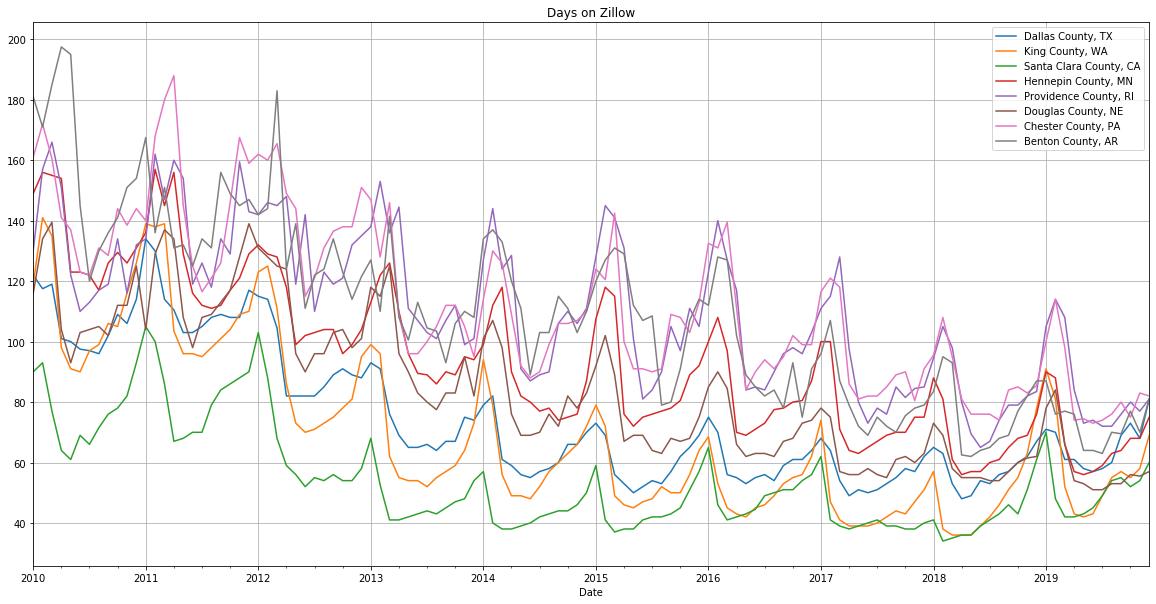

In [193]:
fig0 = z_sets[0].plot(x='Date', kind='line', title=z_names[0], figsize=(20,10), grid=True)

In the above graph, we can see a general downward trend for each of the eight counties we are investigating in terms of how long properties are staying on the market. We observe seasonal trends each year with spikes in winter months and troughs during spring/summer.

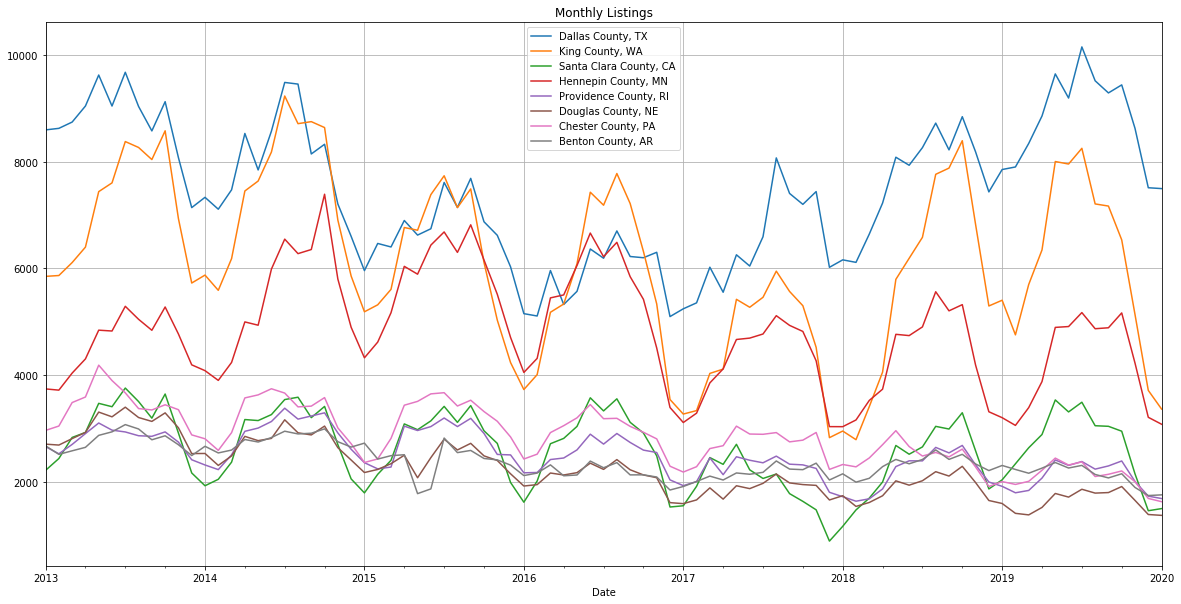

In [194]:
fig1 = z_sets[1].plot(x='Date', kind='line', title=z_names[1], figsize=(20,10), grid=True)

In the above graph, we see similaities between Santa Clara, Providence, Douglas, Chester, and Benton Counties with Dallas, King, and Hennepin Counties showing more variance. Again, we see some seasonal variation with spikes occurring during spring/summer and troughs occuring in winter.

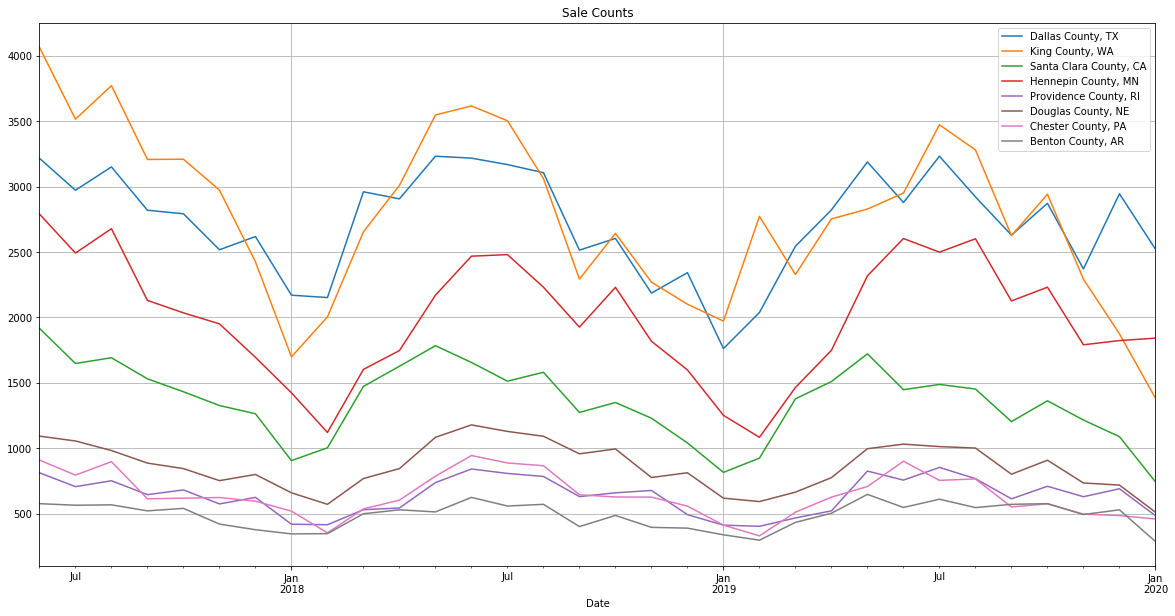

In [195]:
fig2 = z_sets[2].plot(x='Date', kind='line', title=z_names[2], figsize=(20,10), grid=True)

Unfortunately, the sale counts data has less historical information than the previous two sets. Although, we see very similar results as the previous graph. Due to the limited scope of this set, we may end up excluding it later on.

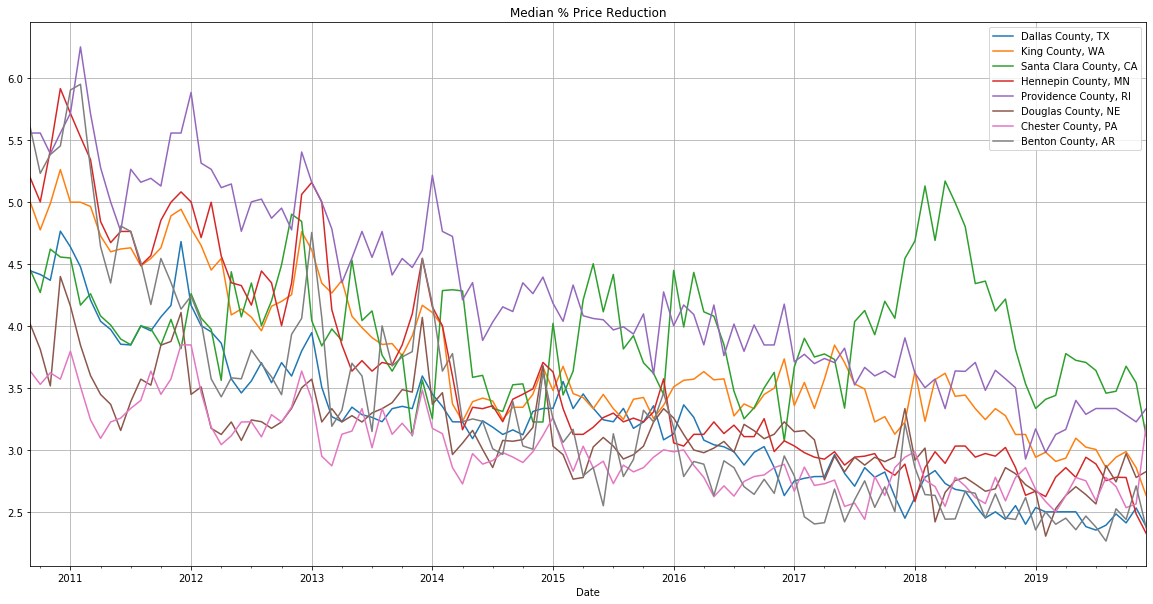

In [196]:
fig3 = z_sets[3].plot(x='Date', kind='line', title=z_names[3], figsize=(20,10), grid=True)

For the most part, we see a downward trend with price reductions over time for these counties. It would be interesting to explore Santa Clara County's economy from 2017-2019 as it shows a noticeable deviation from the downward trend that the other seven counties experienced.

Now that we have done a quick exploration of the Zillow data, it is time that we start evaluating counties on individual levels. Below, we create a function that will parse out the Zillow sets and the top10 dictionary to create dataframes for each county.

In [197]:
# Create county dataframes
def county_df(county_state: str):
    
    stocks = []
    
    for i in range(1,len(top10)+1):
        if top10[i]['county'] in county_state:
            stocks.append((top10[i]['company'], top10[i]['stock']))
    
    df = pd.DataFrame(data={'Date':z_sets[0]['Date'], z_names[0]:z_sets[0][county_state]}).merge(
                            z_sets[1][['Date', county_state]], on=['Date'], how='outer').merge(
                            z_sets[2][['Date', county_state]], on=['Date'], how='outer').merge(
                            z_sets[3][['Date', county_state]], on=['Date'], how='outer')
    
    df.rename(columns={df.columns[2]:z_names[1], df.columns[3]:z_names[2], df.columns[4]:z_names[3]}, inplace=True)
    
    for (c, s) in stocks:
        df = df.merge(s[['Date', 'Adj Close']], on=['Date'], how='outer')
        df.rename(columns={'Adj Close': c}, inplace=True)
        
    return df   

providence = county_df('Providence County, RI')
chester = county_df('Chester County, PA')
douglas = county_df('Douglas County, NE')
benton = county_df('Benton County, AR')
king = county_df('King County, WA')
santa_clara = county_df('Santa Clara County, CA')
hennepin = county_df('Hennepin County, MN')
dallas = county_df('Dallas County, TX')

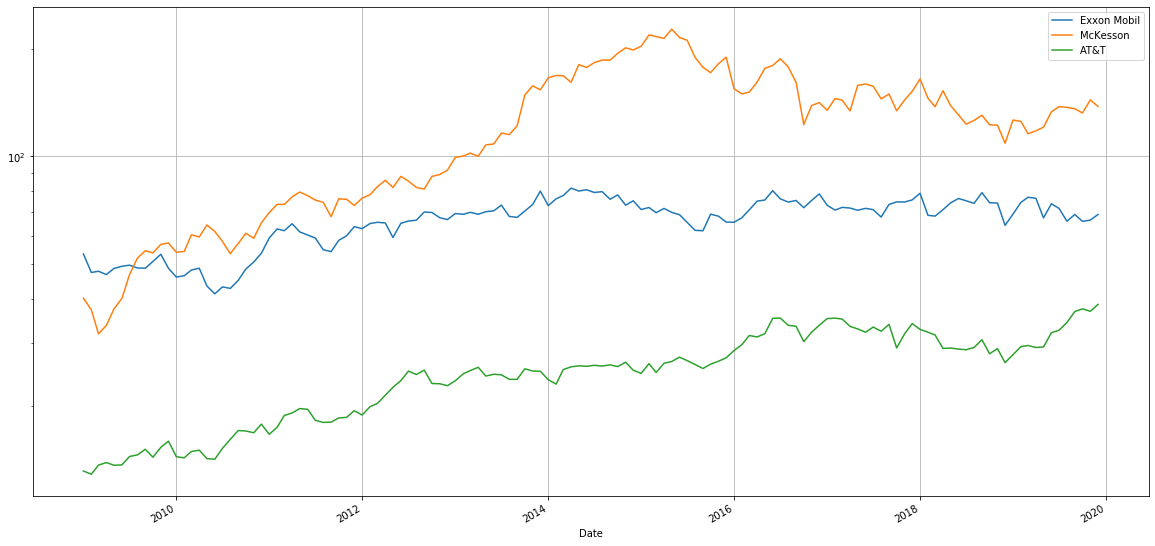

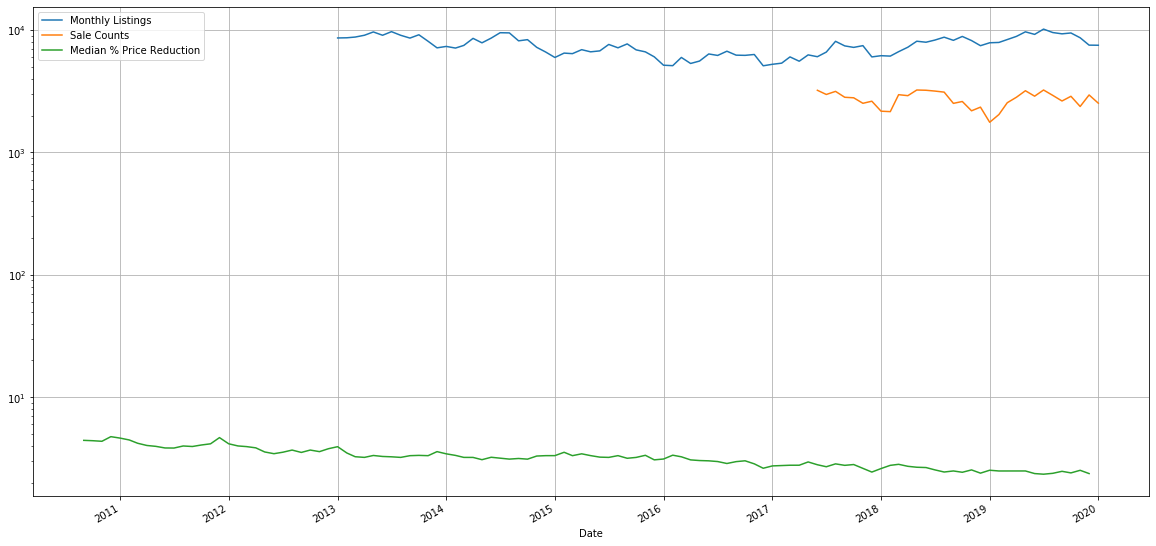

In [218]:
dallas.plot(x='Date', y=dallas.columns[5:], kind='line', figsize=(20,10), grid=True, logy=True)
dallas.plot(x='Date', y=dallas.columns[2:5], kind='line', figsize=(20,10), grid=True, logy=True)

In [75]:
z_sets[0]

,Date,"Dallas County, TX","King County, WA","Santa Clara County, CA","Hennepin County, MN","Providence County, RI","Douglas County, NE","Chester County, PA","Benton County, AR"
0,2010-01-01,122,119,90,149,130,116,161,181
1,2010-02-01,117.5,141,93,156,157,134,172,171
2,2010-03-01,119,135,77,155,166,139.5,160.5,185
3,2010-04-01,101,98,64,154,151,104,141,197.5
4,2010-05-01,100,91,61,123,122,93,137,195
...,...,...,...,...,...,...,...,...,...
115,2019-08-01,60,55,54,63,72,53,76,70
116,2019-09-01,69,57,55,64,76,53,80,69.5
117,2019-10-01,73,55,52,68,80,56,75,77
118,2019-11-01,68,58,54,68,77,55.5,83,70
